# Predicting the sale price of bulldozers using Machine learning

## 1. Problem Definition

> How well can we predict the future sale prices of a bulldozer, given its characteristics.

## 2. Data

The data is downloaded from Kaggle Blue Book for Bulldozers : https://www.kaggle.com/c/bluebook-for-bulldozers/data

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

## 4. Features

Kaggle provides the data dictionary of features of the data set: https://www.kaggle.com/c/bluebook-for-bulldozers/data?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
# import training and validation sets
df = pd.read_csv("Data/TrainAndValid.csv",low_memory=False)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

## Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.
We can do that by telling pandas which of our columns has dates in it using 'parse_dates' parameter

In [5]:
# import data again but this time parse dates
df = pd.read_csv("Data/TrainAndValid.csv",low_memory=False,parse_dates=["saledate"])

In [6]:
df.saledate.dtype

dtype('<M8[ns]')

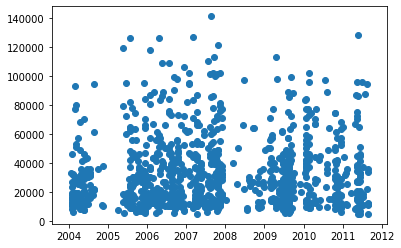

In [7]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000]);

# Sort dateframe by saledate
Whenever we are about to deal with time series data, its good idea to sort it by date.

In [8]:
df.sort_values(by=["saledate"],inplace=True, ascending=True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

Make a copy of the original dataframe so when we manipulate the copy, we have still got the original data.

In [9]:
df_tmp = df.copy()

## Add datetime parameter for 'sale_date' column

In [10]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

# Now we have enriched our data, we can drop "saledate"
df_tmp.drop("saledate", axis=1,inplace=True)

## Convert strings to categories

One way to convert our data into numbers is by converting them into pandas categories.

In [12]:
# Find the columns that contains strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [13]:
# This will change all string values to categories
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

## Fill the missing values

### Fill the numeric missing values

In [14]:
# Check for which numeric column is null
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [15]:
# Fill numeric rows with median
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_tmp[label+"_is_missing"] = pd.isnull(content)
            df_tmp[label] = content.fillna(content.median())

### Fill the categorical missing values

In [16]:
# Check for columns which arent numbers
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [17]:
# Turn categorical variables into numbers and fill them
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_tmp[label+"_is_missing"] = pd.isnull(content)
        df_tmp[label] = pd.Categorical(content).codes + 1

In [20]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

# 5. Modelling

In [21]:
%%time
X = df_tmp.drop("SalePrice",axis=1)
y = df_tmp["SalePrice"]

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,random_state=42)

model.fit(X,y)

Wall time: 8min 49s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### Split the data into Training and Validation sets

In [22]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

In [24]:
# Split data into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

### Create Evaluation function

In [30]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

def rmsle(y_test,y_preds):
    return np.sqrt(mean_squared_log_error(y_test,y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train,train_preds),
              "valid MAE": mean_absolute_error(y_valid,val_preds),
              "Training RMSLE": rmsle(y_train,train_preds),
              "Valid RMSLE": rmsle(y_valid,val_preds)}
    return scores


Reduce the data as we have 4lack records and it takes time to fit and score

In [27]:
# change max_sample value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

In [28]:
%%time
model.fit(X_train,y_train)

Wall time: 22.3 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=10000, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [31]:
show_scores(model)

{'Training MAE': 5561.2988092240585,
 'valid MAE': 7177.26365505919,
 'Training RMSLE': 0.257745378256977,
 'Valid RMSLE': 0.29362638671089003}

### RandomizedSearchCV

In [33]:
%%time
from sklearn.model_selection import RandomizedSearchCV

grid = {"n_estimators": np.arange(10,100,10),
        "max_depth": [None, 3,5,10],
        "min_samples_split": np.arange(2,20,2),
        "min_samples_leaf": np.arange(2,20,2),
        "max_samples": [10000],
        "max_features":[0.5,1,"sqrt","auto"]}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                            param_distributions=grid,
                            n_iter=2,
                            cv=5,
                            verbose=True)

rs_model.fit(X_train,y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  1.9min finished


Wall time: 1min 58s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [34]:
%%time
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)

ideal_model.fit(X_train,y_train)

Wall time: 1min 35s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=14, min_weight_fraction_leaf=0.0,
                      n_estimators=40, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [35]:
show_scores(ideal_model)

{'Training MAE': 2956.34948074171,
 'valid MAE': 5962.871635334203,
 'Training RMSLE': 0.14472794041489687,
 'Valid RMSLE': 0.24590633186070007}

## Make prediction on test data

In [44]:
df_test = pd.read_csv("Data/Test.csv",low_memory=False,parse_dates=["saledate"])

#### Preprocessing the data

In [45]:
def preprocess_data(df):
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayOfWeek"] = df.saledate.dt.dayofweek
    df["saleDayOfYear"] = df.saledate.dt.dayofyear
    
    df.drop("saledate",axis=1,inplace=True)
    
    #fill numeric missing with median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
            
    #fill categorical missing with median
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            df[label] = pd.Categorical(content).codes+1
            
    return df

In [46]:
df_test = preprocess_data(df_test)

In [47]:
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

In [48]:
# Manually add a column 'auctioneerID_is_missing'
df_test["auctioneerID_is_missing"] = False

In [49]:
test_preds = ideal_model.predict(df_test)

In [51]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,19236.435076
1,1227844,20405.636890
2,1227847,52697.282368
3,1227848,65875.267091
4,1227863,50496.222102
...,...,...
12452,6643171,40906.394370
12453,6643173,12187.498092
12454,6643184,12352.012522
12455,6643186,18994.896820


## Feature Importance